# Image segmentation training for peat detection


Author: Jürgen Landauer, juergenlanduaer@gmx.de

Some basic parameters:

In [ ]:
VERSION = "S020b"

#FIND_LR = False
FIND_LR = True

TESTRUN = True
#TESTRUN = False

installing libraries

In [ ]:
snippetSize = 256
overlap=0.25

In [ ]:
root_dir = "./gdrive/MyDrive/Peat"

In [ ]:
# try: # try if we are on Google Colab
try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)

    # download images
    snippets = root_dir+'/Data/snippets'  +str(snippetSize)+"+"+str(overlap)+'.zip'
    masks    = root_dir+'/Data/masks'+str(snippetSize)+"+"+str(overlap)+'.zip'
    !rm -rf snippets segmasks *.zip
    !cp $snippets $masks .
    !unzip  -q snippets*.zip -d snippets
    !unzip  -q masks*.zip -d segmasks
except ModuleNotFoundError: # no Colab, so we are local
    root_dir = "../Data"

root_dir, snippets, masks

Mounted at /content/gdrive


('./gdrive/MyDrive/Peat',
 './gdrive/MyDrive/Peat/Data/snippets256+0.25.zip',
 './gdrive/MyDrive/Peat/Data/masks256+0.25.zip')

In [ ]:
!ls -l segmasks|wc

  12187  131024 1182457


In [ ]:
!ls -l snippets|wc

  12187  131024 1206831


In [ ]:
#Run this once per session
!pip install fastai -q --upgrade
!pip install git+https://github.com/WaterKnight1998/SemTorch -q
!pip install -q pytorch_toolbelt


     |████████████████████████████████| 225 kB 6.8 MB/s 
     |████████████████████████████████| 173 kB 7.3 MB/s 


# Libraries

In [ ]:
from fastai.vision.all import *
import pandas as pd
import gc # garbage collector
import glob

# SemTorch
from semtorch import get_segmentation_learner

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
# fix randomness
my_seed = 42
np.random.seed(my_seed);random.seed(my_seed);set_seed(my_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create dataset


In [ ]:
imgfiles = glob.glob("./snippets/*.png")
len(imgfiles)

12186

In [ ]:
#put it into a dataframe
df = pd.DataFrame(imgfiles, columns=["fpath"])
# extract the coverage percentage into a separate column 'pct'
df["pct"] = df["fpath"].str.split("_").str[-1].str.split(".png").str[0].astype(float)
df.head()

,fpath,pct
0,./snippets/BB17_pt2_8001 - 12000v2.jpg_512_192_0.0.png,0.0
1,./snippets/BB17_pt2_16001 - 20000v2.jpg_128_64_0.0.png,0.0
2,./snippets/BB09_RAW_LF_36000 - 40000.jpg_960_192_0.0.png,0.0
3,./snippets/BB7_WE_pt1_80001-84000v2.jpg_1024_320_0.0.png,0.0
4,./snippets/BB17_pt2_28001 - 32000v2.jpg_512_256_0.0.png,0.0


### Exploratory Data Analysis

In [ ]:
# my histogram convenience plotter func
def my_hist(df):
    plt.figure(figsize=(8,4))
    plt.hist(df['pct'], bins=50)
    plt.show()

In [ ]:
# how many are empty, i.e. have no peat in their masks?
len(df[df['pct'] == 0])

7640

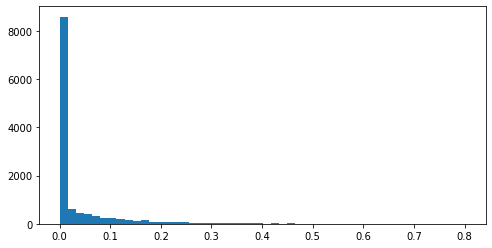

0.03417258526369912

In [ ]:
# what is the distribution and the mean?
my_hist(df)
df['pct'].mean()

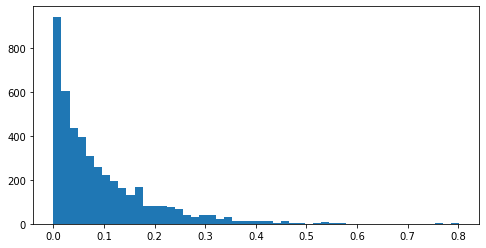

In [ ]:
# same for these with at least some peat
my_hist(df[((df['pct'] > 0.0001) )])

In [ ]:
peat_thresh = 0.05 # was 0.005

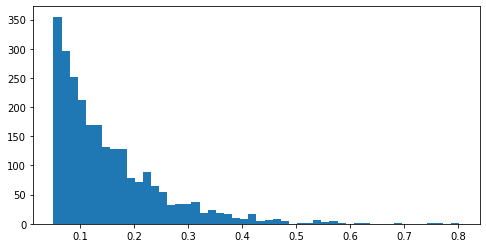

In [ ]:
# same for these with at least some peat
my_hist(df[((df['pct'] > peat_thresh) )])

In [ ]:
#Remove these with pct > peat_thresh
df = df[df['pct'] > peat_thresh]
len(df)

2497

## Configuration

In [ ]:
# what class are we looking for?
myclass = "peat"

In [ ]:
codes = np.array(['background', myclass])
codes

array(['background', 'peat'], dtype='<U10')

In [ ]:
# modified from https://walkwithfastai.com/Binary_Segmentation
#myemptymask = np.zeros(sz, dtype=np.int8)
def get_msk(row):
    fn = Path(row["fpath"])
    msk_fn = fn.parent.parent/'segmasks'/fn.name
    pix = np.array(PILMask.create(msk_fn))
    pix[pix>0] = 1 # foreground
    #return pix
    return PILMask.create(pix)

### Progressive resizing

This first round we will train at a smaller image size, often half

In [ ]:
sz = snippetSize
sz

256

In [ ]:
half = sz // 2

### augmentation transforms

In [ ]:
# define augmentation transforms
def my_transforms(imgsize):
    item_tfms = None#[Resize(imgsize)]
    batch_tfms=[*aug_transforms(size=imgsize,
                    do_flip=True, flip_vert=False,
                    xtra_tfms=[RandomErasing(p=0.5, sl=0.0, sh=0.2, min_aspect=0.3, max_count=6)],
                    max_rotate=0, max_warp=0), Normalize.from_stats(*imagenet_stats)]
    return item_tfms, batch_tfms

In [ ]:
#Test
#my_transforms(sz)

### Dataloaders

In [ ]:
# shuffle dataframe, just in case!
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# function for retrieving a dataloaders object for a 'fold'
def get_data(mydf, fold, n_splits, codes, bs, item_tfms, batch_tfms):
    length = int(len(mydf)/n_splits)
    start = fold*length

    # this adds an 'is_valid' column
    mydf['is_valid'] = False
    mydf.loc[start:start+length,'is_valid'] = True
    # the datablock
    dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                   #splitter=RandomSplitter(valid_pct=0.2),
                   splitter=ColSplitter(), #!!! is_valid is in valid_ds
                   get_x=ColReader('fpath'),
                   get_y=get_msk, item_tfms=item_tfms, batch_tfms=batch_tfms)
    # the dataloaders
    dls = dblock.dataloaders(mydf, path='', bs=bs)
    return dls

In [ ]:
# optimizer: we use Ranger instead of Adam
#opt = Adam
opt = ranger

In [ ]:
# we use IoU as metric, which is the same as Jaccard.
metrics = [JaccardCoeff()]

### Class imbalance

The dataset is imbalanced with only some N percent of all pixels containing Forts

In [ ]:
import pytorch_toolbelt.losses as L

lovasz = L.LovaszLoss()

def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz(outputs, targets) + lovasz(-outputs, 1.0 - targets))

myloss_func = symmetric_lovasz

In [ ]:
myloss_func=FocalLossFlat(axis=1)

In [ ]:
def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)]

In [ ]:
#arch="hrnet";backbone="hrnet_w30"

#arch="deeplabv3+";backbone="resnet101"
#arch="deeplabv3+";backbone="resnet50"
arch="deeplabv3+";backbone="resnet34"
#arch="deeplabv3+";backbone="resnet18"

arch, backbone

('deeplabv3+', 'resnet34')

In [ ]:
# these callbacks are used during training. The first three monitor training progress, Cutmix is for augmentation.
callbacks = [SaveModelCallback(monitor='jaccard_coeff'),
             EarlyStoppingCallback(monitor='jaccard_coeff', patience=12),
             ReduceLROnPlateau(monitor='jaccard_coeff'),
             #MixUp(),
             #CutMix()
            ]

## we should try Mixup and CutMix

In [ ]:
# we use the flat cosine annealing training loop along with fastai's default fine_tune(), so we create
# our own fine_tune_flat(), modelled after Zachary Mueller's notebook from here:
# https://www.kaggle.com/muellerzr/cassava-fastai-starter

@patch
def fine_tune_flat(self:Learner, epochs, base_lr=4e-3, freeze_epochs=1, lr_mult=100, pct_start=0.75,
                   first_callbacks = [], second_callbacks = [], tofp32=False,**kwargs):
    "Fine-tune applied to `fit_flat_cos`"
    self.freeze()
    self.fit_flat_cos(freeze_epochs, slice(base_lr), pct_start=0.99, cbs=first_callbacks, **kwargs)
    gc.collect();torch.cuda.empty_cache()
    base_lr /= 2
    self.unfreeze()
    if tofp32: self.to_fp32() # set to 32 bit
    self.fit_flat_cos(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, cbs=second_callbacks)
    gc.collect();torch.cuda.empty_cache()

### k-fold loop:

In [ ]:
n_folds = 5

we have two training cycles, one with half size images, one with full size images:

## half size training cycle

In [ ]:
# batch size
bs = 128 # up to 128 possible

bs

128

In [ ]:
 # define augmentation transforms
item_tfms, batch_tfms = my_transforms(half)

In [ ]:
dls = get_data(df, 0, n_folds, codes, bs, item_tfms, batch_tfms) # get the dataloaders

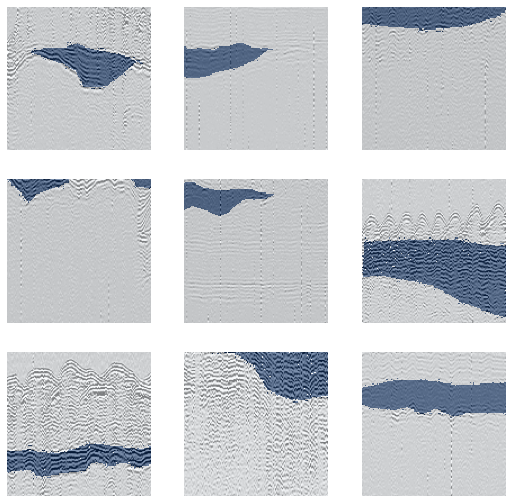

In [ ]:
dls.show_batch(cmap='Blues', vmin=0, vmax=1)

#### Optional: find good learning rate

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

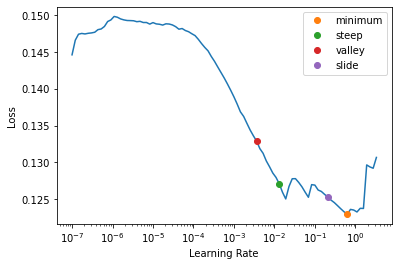

In [ ]:
if FIND_LR:
    dls = get_data(df, 0, n_folds, codes, bs, item_tfms, batch_tfms) # get the dataloaders
    learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                     architecture_name=arch, backbone_name=backbone, metrics=metrics,
                                     splitter=segmentron_splitter, opt_func=opt,

                                     #wd=1e-3,############!!!!!!!!!!!!!!!!!!!!!!!

                                     loss_func=myloss_func).to_fp16() # we use fp16 training
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
if FIND_LR: print(lrs)

SuggestedLRs(minimum=0.06309573650360108, steep=0.013182567432522774, valley=0.00363078061491251, slide=0.2089296132326126)


In [ ]:
#set hyperparameters:#
#lr = 8e-4
lr = lrs.valley #1e-2
if not FIND_LR:
    lr = 1e-2

freeze_epochs = 3
epochs = 35#50

lr, freeze_epochs, epochs

(0.01, 3, 35)

--- fold # 0


epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.129211,0.107282,0.000000,00:14
1,0.111839,0.095656,0.002992,00:12
2,0.102913,0.081990,0.190126,00:13


Better model found at epoch 0 with jaccard_coeff value: 0.0.
Better model found at epoch 1 with jaccard_coeff value: 0.0029921394620073998.
Better model found at epoch 2 with jaccard_coeff value: 0.1901261237906986.


epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.088613,0.079697,0.202115,00:14
1,0.086842,0.078624,0.160857,00:14
2,0.084390,0.074955,0.234022,00:14
3,0.082101,0.070436,0.327369,00:14
4,0.079881,0.068294,0.377339,00:14
5,0.077686,0.064878,0.364340,00:14
6,0.076251,0.063537,0.386533,00:14
7,0.073958,0.059992,0.437392,00:14
8,0.071698,0.063165,0.418755,00:14
9,0.069497,0.056613,0.464361,00:14


Better model found at epoch 0 with jaccard_coeff value: 0.20211508473631476.
Epoch 1: reducing lr to 0.0005
Better model found at epoch 2 with jaccard_coeff value: 0.23402235420317904.
Better model found at epoch 3 with jaccard_coeff value: 0.3273690919998286.
Better model found at epoch 4 with jaccard_coeff value: 0.3773391577015759.
Epoch 5: reducing lr to 0.0005
Better model found at epoch 6 with jaccard_coeff value: 0.38653302303164394.
Better model found at epoch 7 with jaccard_coeff value: 0.43739214515146857.
Epoch 8: reducing lr to 0.0005
Better model found at epoch 9 with jaccard_coeff value: 0.46436129409012017.
Better model found at epoch 10 with jaccard_coeff value: 0.4986112159604737.
Better model found at epoch 11 with jaccard_coeff value: 0.5062928215718542.
Better model found at epoch 12 with jaccard_coeff value: 0.5144145704035972.
Better model found at epoch 13 with jaccard_coeff value: 0.5564283212170437.
Better model found at epoch 14 with jaccard_coeff value: 0.559

--- fold complete # 0 [0.028201935812830925, 0.7313315234960316]
-----------------


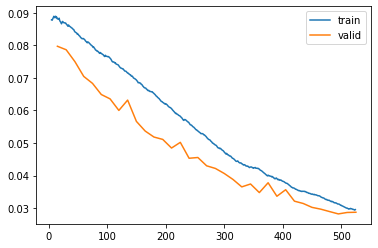

In [ ]:
for fold in range(n_folds):
    print ("--- fold #", fold)
    dls = get_data(df, fold, n_folds, codes, bs, item_tfms, batch_tfms) # get the dataloaders
    # here we create the segmentation learner with SemTorch. The models are all pre-trained on ImageNet
     # here is the training cycle: we train for 'freeze_epochs' with all layers (except the last) frozen,
    # then we train for 'epochs' with all layers unfrozen
    learn.fine_tune_flat(epochs, lr, freeze_epochs, first_callbacks=callbacks, second_callbacks=callbacks)
    learn.recorder.plot_loss()
    learn.to_fp32() # needed?
    learn.export('models/stage-1_'+arch+'_'+VERSION+'_'+myclass+str(fold))
    print ("--- fold complete #", fold, learn.validate())
    print ("-----------------")
    del dls#, learn # free memory
    if TESTRUN: break # leave after first fold


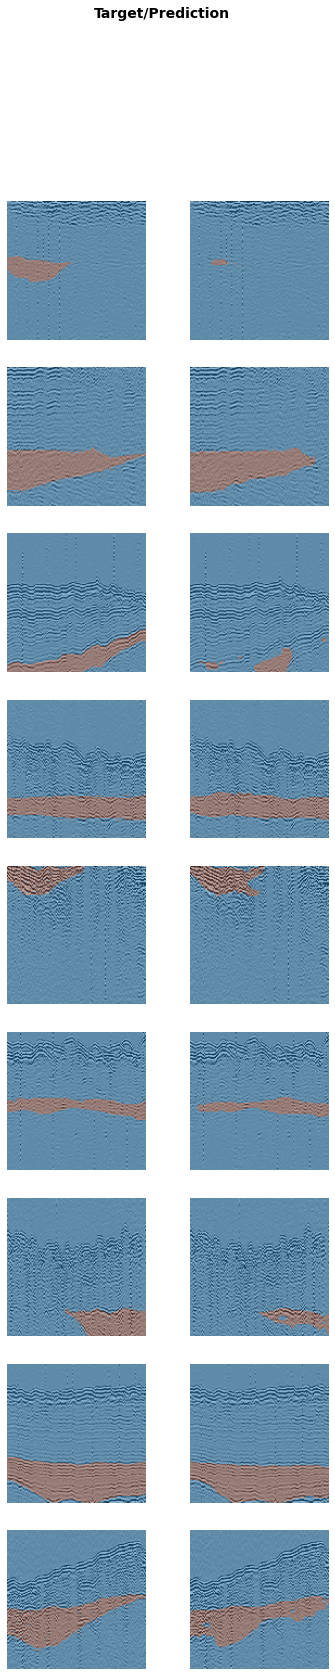

In [ ]:
learn.show_results()

# Full size training cycle

In [ ]:
# sz is full size now, so we need new transforms
item_tfms, batch_tfms = my_transforms(sz)

In [ ]:
# reduce the batch size
bs = 32
bs

32

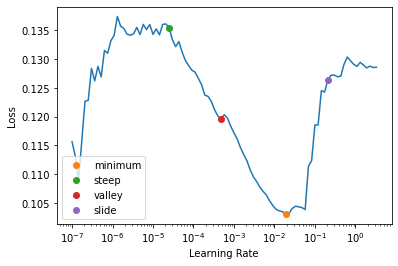

In [ ]:
if FIND_LR:
    dls = get_data(df, 0, n_folds, codes, bs, item_tfms, batch_tfms) # get dataloaders
    learn = load_learner('models/stage-1_'+arch+'_'+VERSION+'_'+myclass+str(0)) # re-load the learner
    learn.dls = dls # and insert the new dataloaders
    learn.to_fp16() # switch into fp16 training (half precision)
    learn.loss_func = myloss_func # set loss function
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
if FIND_LR: print(lrs)

SuggestedLRs(minimum=0.0019054606556892395, steep=2.511886486900039e-05, valley=0.0004786300996784121, slide=0.2089296132326126)


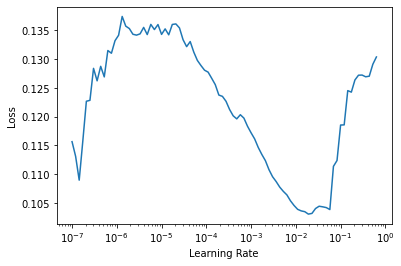

In [ ]:
if FIND_LR: learn.recorder.plot_lr_find(skip_end=14)

In [ ]:
# set hyperparameters
lr = lrs.valley
if not FIND_LR:
    lr = 4e-3

freeze_epochs = 3
epochs = 45

lr, freeze_epochs, epochs

(0.004, 3, 45)

--- fold # 0


epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.074647,0.055762,0.477800,00:39
1,0.061411,0.047355,0.546209,00:39
2,0.054249,0.040853,0.620765,00:39


Better model found at epoch 0 with jaccard_coeff value: 0.4778002299836505.
Better model found at epoch 1 with jaccard_coeff value: 0.5462088975544621.
Better model found at epoch 2 with jaccard_coeff value: 0.6207648752927365.


epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.043222,0.038562,0.637349,00:28
1,0.041264,0.035930,0.669886,00:28
2,0.038207,0.032100,0.701509,00:28
3,0.036600,0.029298,0.722207,00:28
4,0.035087,0.028196,0.737614,00:28
5,0.032077,0.025742,0.758989,00:28
6,0.030577,0.025518,0.761454,00:28
7,0.028933,0.024217,0.770308,00:28
8,0.027129,0.021573,0.792158,00:28
9,0.026583,0.022067,0.788843,00:28


Better model found at epoch 0 with jaccard_coeff value: 0.6373488082303933.
Better model found at epoch 1 with jaccard_coeff value: 0.6698862665729758.
Better model found at epoch 2 with jaccard_coeff value: 0.7015092598809998.
Better model found at epoch 3 with jaccard_coeff value: 0.7222065468762644.
Better model found at epoch 4 with jaccard_coeff value: 0.7376140534989892.
Better model found at epoch 5 with jaccard_coeff value: 0.758989055732297.
Better model found at epoch 6 with jaccard_coeff value: 0.7614542552071474.
Better model found at epoch 7 with jaccard_coeff value: 0.7703084783235987.
Better model found at epoch 8 with jaccard_coeff value: 0.7921579479593129.
Epoch 9: reducing lr to 0.0002
Better model found at epoch 10 with jaccard_coeff value: 0.7933277628597879.
Better model found at epoch 11 with jaccard_coeff value: 0.814358424068022.
Better model found at epoch 12 with jaccard_coeff value: 0.8144828964535709.
Better model found at epoch 13 with jaccard_coeff value:

--- fold complete # 0 [0.010373307392001152, 0.8990564591916753]
-----------------


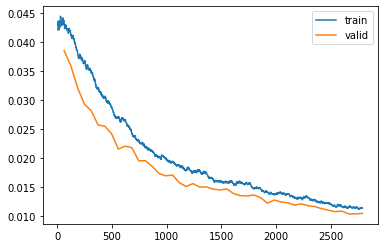

In [ ]:
# we iterate over each fold
for fold in range(n_folds):
    print ("--- fold #", fold)
    dls = get_data(df, fold, n_folds, codes, bs, item_tfms, batch_tfms) # get dataloaders
    learn = load_learner('models/stage-1_'+arch+'_'+VERSION+'_'+myclass+str(fold)) # re-load the learner
    learn.dls = dls # and insert the new dataloaders
    learn.to_fp16() # switch into fp16 training (half precision)
    learn.loss_func = myloss_func # set loss function
    # note that we now fine tune again but 2nd cycle with full precision (tofp32)
    learn.fine_tune_flat(epochs, lr, freeze_epochs, first_callbacks=callbacks, second_callbacks=callbacks,
                         tofp32=True)
    learn.recorder.plot_loss()
    MYMODEL = "models/m_"+arch+'_'+VERSION+"_"+myclass+str(fold)+".pkl"
    print (MYMODEL)
    print ("--- fold complete #", fold, learn.validate())
    print ("-----------------")
    learn.export(MYMODEL)
    del dls#, learn
    if TESTRUN: break

# beat 0.61-0.69

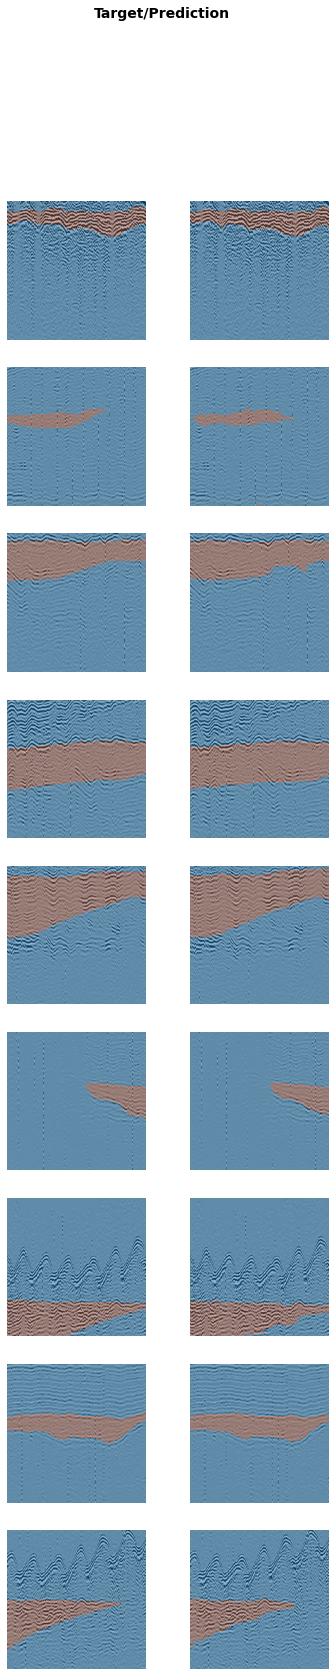

In [ ]:
learn.show_results()

In [ ]:
MYMODEL = "models/m_"+arch+'_'+VERSION+"_"+myclass+str(fold)+".pkl"
learn.export(MYMODEL)


### store model in Gdrive

In [ ]:
!cp $MYMODEL $root_dir/Models

# END